In [2]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset=pd.read_csv(r"C:\Users\RIYA BANERJEE\Desktop\pythonfile\python.py\finalyearproject\breast_cancer_2000.csv")
dataset.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


In [4]:
dataset.shape

(2000, 31)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, Binarizer
from sklearn.impute import SimpleImputer

In [7]:
# auto-detect or set the target column
if 'diagnosis' in dataset.columns:
    target_col = 'diagnosis'
else:
    # fallback: pick last column (adjust if needed)
    target_col = dataset.columns[-1]
    print("Using", target_col, "as target")

# map common labels to 0/1: 1 = malignant/positive, 0 = benign/negative
y_raw = dataset[target_col].astype(str).str.strip().str.lower()

# common mappings
if set(y_raw.unique()) <= set(['m','b']):
    y = y_raw.map({'m':1,'b':0}).astype(int)
elif set(y_raw.unique()) <= set(['malignant','benign']):
    y = y_raw.map({'malignant':1,'benign':0}).astype(int)
elif set(y_raw.unique()) <= set(['1','0']):
    y = y_raw.astype(int)
else:
    # generic: factorize then map the larger-risk class to 1 (the minority)
    codes, uniques = pd.factorize(y_raw)
    if len(uniques) == 2:
        # map second unique to 1 by default
        mapping = {uniques[0]:0, uniques[1]:1}
        y = pd.Series([mapping[val] for val in y_raw]).astype(int)
    else:
        raise ValueError("Target has >2 classes or unexpected labels. Edit mapping manually.")

# drop ID-like columns (if any) but keep the target
drop_cols = [c for c in dataset.columns if re.search(r'id|patient|index', c, re.I) and c != target_col]
# Automatically select first 10 features (excluding target)
X = dataset.drop(columns=[target_col]).iloc[:, :10]
y = dataset[target_col]

print("X shape:", X.shape, "y distribution:\n", y.value_counts())


X shape: (2000, 10) y distribution:
 diagnosis
1    1000
0    1000
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1600, 10) Test: (400, 10)


In [9]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Standard preprocessor: median imputation + StandardScaler (for LR, KNN, SVM, GaussianNB)
preprocessor_std = ColumnTransformer(transformers=[
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), numeric_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols),
])

# Non-negative preprocessor: MinMax scaling to [0,1] (for MultinomialNB / BernoulliNB)
preprocessor_nonneg = ColumnTransformer(transformers=[
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]), numeric_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols),
])

# Binarizer for BernoulliNB (applied after MinMax -> values in [0,1])
binarizer = Binarizer(threshold=0.5)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [11]:
# Logistic Regression
pipe_lr = Pipeline([
    ("prep", preprocessor_std),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# K-Nearest Neighbors
pipe_knn = Pipeline([
    ("prep", preprocessor_std),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

# Gaussian Naive Bayes (works well with standardized continuous features)
pipe_gnb = Pipeline([
    ("prep", preprocessor_std),
    ("clf", GaussianNB())
])

# Multinomial Naive Bayes (needs non-negative features)
pipe_mnb = Pipeline([
    ("prep", preprocessor_nonneg),
    ("clf", MultinomialNB())
])

# Bernoulli Naive Bayes (binary features)
pipe_bnb = Pipeline([
    ("prep", preprocessor_nonneg),
    ("bin", binarizer),
    ("clf", BernoulliNB())
])

# SVM with RBF kernel
pipe_svm = Pipeline([
    ("prep", preprocessor_std),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

# Random Forest (trees don't need scaling)
pre_tf_for_trees = ColumnTransformer(transformers=[
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols),
])
pipe_rf = Pipeline([
    ("prep", pre_tf_for_trees),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Decision Tree
pipe_dt = Pipeline([
    ("prep", pre_tf_for_trees),
    ("clf", DecisionTreeClassifier(random_state=42))
])


In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    # try to get probabilities for ROC-AUC; fall back to decision_function if available
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X_test)
        # scale to [0,1]
        y_score = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        # fallback: use predictions as scores (not ideal for AUC)
        y_score = y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc = roc_auc_score(y_test, y_score)
    except Exception:
        roc = float("nan")

    print(f"--- {name} ---")
    print(f"Accuracy:  {acc:.4f}   Precision: {prec:.4f}   Recall: {rec:.4f}   F1: {f1:.4f}   ROC-AUC: {roc:.4f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print()
    return dict(model=name, accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc)


In [13]:
results = []

# Logistic Regression
pipe_lr.fit(X_train, y_train)
results.append(evaluate_model("LogisticRegression", pipe_lr, X_test, y_test))

--- LogisticRegression ---
Accuracy:  0.9600   Precision: 0.9646   Recall: 0.9550   F1: 0.9598   ROC-AUC: 0.9949
Confusion matrix:
[[193   7]
 [  9 191]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.95      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400




In [14]:
# KNN
pipe_knn.fit(X_train, y_train)
results.append(evaluate_model("KNN", pipe_knn, X_test, y_test))

--- KNN ---
Accuracy:  0.9950   Precision: 0.9950   Recall: 0.9950   F1: 0.9950   ROC-AUC: 0.9971
Confusion matrix:
[[199   1]
 [  1 199]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400




In [15]:
# GaussianNB
pipe_gnb.fit(X_train, y_train)
results.append(evaluate_model("GaussianNB", pipe_gnb, X_test, y_test))

--- GaussianNB ---
Accuracy:  0.9450   Precision: 0.9734   Recall: 0.9150   F1: 0.9433   ROC-AUC: 0.9904
Confusion matrix:
[[195   5]
 [ 17 183]]
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       200
           1       0.97      0.92      0.94       200

    accuracy                           0.94       400
   macro avg       0.95      0.95      0.94       400
weighted avg       0.95      0.94      0.94       400




In [16]:
# MultinomialNB
pipe_mnb.fit(X_train, y_train)
results.append(evaluate_model("MultinomialNB", pipe_mnb, X_test, y_test))

--- MultinomialNB ---
Accuracy:  0.8800   Precision: 0.8878   Recall: 0.8700   F1: 0.8788   ROC-AUC: 0.9495
Confusion matrix:
[[178  22]
 [ 26 174]]
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       200
           1       0.89      0.87      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400




In [17]:
# BernoulliNB
pipe_bnb.fit(X_train, y_train)
results.append(evaluate_model("BernoulliNB", pipe_bnb, X_test, y_test))

--- BernoulliNB ---
Accuracy:  0.8300   Precision: 0.9583   Recall: 0.6900   F1: 0.8023   ROC-AUC: 0.8784
Confusion matrix:
[[194   6]
 [ 62 138]]
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       200
           1       0.96      0.69      0.80       200

    accuracy                           0.83       400
   macro avg       0.86      0.83      0.83       400
weighted avg       0.86      0.83      0.83       400




In [18]:
# SVM (RBF)
pipe_svm.fit(X_train, y_train)
results.append(evaluate_model("SVM_RBF", pipe_svm, X_test, y_test))

--- SVM_RBF ---
Accuracy:  0.9825   Precision: 1.0000   Recall: 0.9650   F1: 0.9822   ROC-AUC: 0.9983
Confusion matrix:
[[200   0]
 [  7 193]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       200
           1       1.00      0.96      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400




In [19]:
# Random Forest
pipe_rf.fit(X_train, y_train)
results.append(evaluate_model("RandomForest", pipe_rf, X_test, y_test))

--- RandomForest ---
Accuracy:  0.9875   Precision: 0.9949   Recall: 0.9800   F1: 0.9874   ROC-AUC: 0.9987
Confusion matrix:
[[199   1]
 [  4 196]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       200
           1       0.99      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400




In [20]:
# Decision Tree
pipe_dt.fit(X_train, y_train)
results.append(evaluate_model("DecisionTree", pipe_dt, X_test, y_test))

--- DecisionTree ---
Accuracy:  0.9750   Precision: 0.9897   Recall: 0.9600   F1: 0.9746   ROC-AUC: 0.9750
Confusion matrix:
[[198   2]
 [  8 192]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       200
           1       0.99      0.96      0.97       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400




,model,accuracy,precision,recall,f1,roc_auc
6,RandomForest,0.9875,0.994924,0.980,0.987406,0.998725
5,SVM_RBF,0.9825,1.000000,0.965,0.982188,0.998350
1,KNN,0.9950,0.995000,0.995,0.995000,0.997112
0,LogisticRegression,0.9600,0.964646,0.955,0.959799,0.994900
2,GaussianNB,0.9450,0.973404,0.915,0.943299,0.990425
7,DecisionTree,0.9750,0.989691,0.960,0.974619,0.975000
3,MultinomialNB,0.8800,0.887755,0.870,0.878788,0.949450
4,BernoulliNB,0.8300,0.958333,0.690,0.802326,0.878425


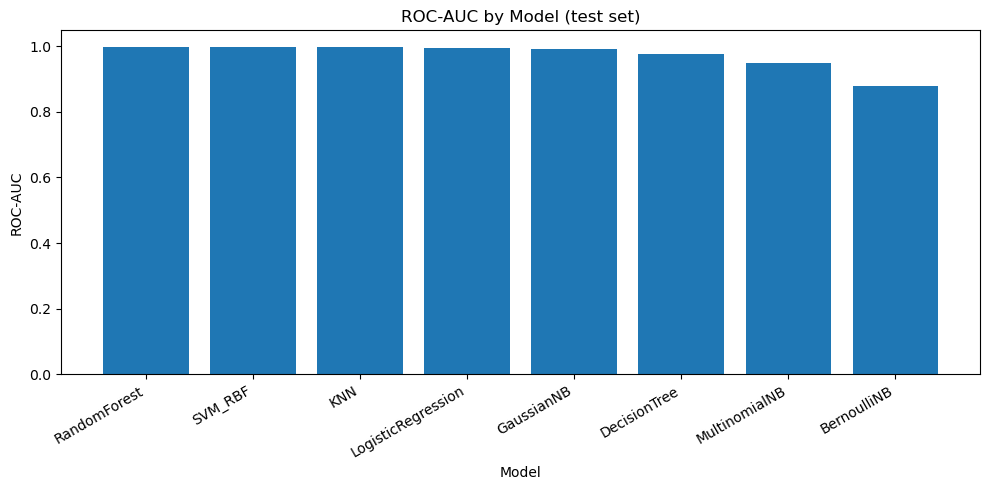

Saved metrics_summary.csv and all joblib models in current folder.


In [21]:
metrics_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
display(metrics_df)

# simple ROC-AUC bar plot
plt.figure(figsize=(10,5))
plt.bar(metrics_df['model'], metrics_df['roc_auc'])
plt.ylabel("ROC-AUC")
plt.xlabel("Model")
plt.title("ROC-AUC by Model (test set)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# save summary
metrics_df.to_csv("metrics_summary.csv", index=False)
print("Saved metrics_summary.csv and all joblib models in current folder.")


In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.985

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       200
           1       0.99      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.98       400
weighted avg       0.99      0.98      0.98       400



In [23]:
import pickle

In [24]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)